In [1]:
import fitter as fitter

from channel_analyser import channel

import numpy as np
import matplotlib.pyplot as plt
plt.style.use("science")

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-cwzsw0km because the default path (/afs/ihep.ac.cn/users/m/miaoyu/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [13]:
## Channel configuration:

model = "Garching"
modelNo = 82703
dist = 10

channels = {}
channels["eES"] = channel("eES", "NO", "Garching", 82703, 5.0, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="SuperK")
channels["IBD"] = channel("IBD", "NO", "Garching", 82703, 5.0, fitTmin=-0.02, fitTmax=0.02, dist=dist, exp="SuperK")

scale = 100 / dist**2

for cha in channels.values():
    cha.setScale(scale)
    # set pdf file names:
    cha.setNOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_NO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_SuperK.root")
    cha.setIOPdfFilePath(f"/junofs/users/miaoyu/supernova/simulation/C++/jobs/{model}{modelNo}_PDF_IO_10kpc_{cha.name}_{cha.Ethr:.2f}MeV_SuperK.root")

    cha._load_pdf()



 ========= Load eES 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_eES_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_eES_0.20MeV_newshortPDF_v2.root

 ========= Load IBD 1D PDF ========= 

/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_NO_10kpc_IBD_0.20MeV_newshortPDF_v2.root
/junofs/users/miaoyu/supernova/simulation/C++/jobs/Garching82703_PDF_IO_10kpc_IBD_0.20MeV_newshortPDF_v2.root


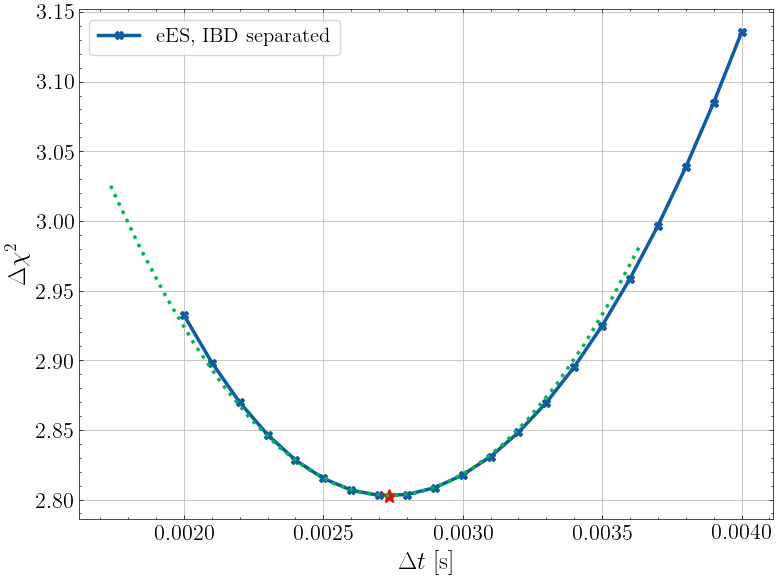

In [17]:
from importlib import reload
reload(fitter)

MO = "IO"
dist = 10
scale = 100 / dist**2
for cha in channels.values():
    cha.setScale(scale)

# coarse scanning
dt_arr = np.arange(-0.01, 0.011, 0.001)
dchi2_arr = fitter.scanning_asimov1D_combined(dt_arr, channels["eES"], channels["IBD"], MO)
Tbest, locMin, _ = fitter.find_locMin(dt_arr, dchi2_arr)
dchi2_arr_sep = fitter.scanning_asimov1D_separate(dt_arr, channels.values(), MO)
Tbest_sep, locMin_sep, _ = fitter.find_locMin(dt_arr, dchi2_arr_sep)
# fine scanning
dt_arr = fitter.generate_fine_dtarr(Tbest)
dchi2_arr = fitter.scanning_asimov1D_combined(dt_arr, channels["eES"], channels["IBD"], MO)
Tbest, locMin, a, b, c = fitter.parabola_fit(dt_arr, dchi2_arr)
dt_arr_sep = fitter.generate_fine_dtarr(Tbest_sep)
dchi2_arr_sep = fitter.scanning_asimov1D_separate(dt_arr_sep, channels.values(), MO)
Tbest_sep, locMin_sep, a_sep, b_sep, c_sep = fitter.parabola_fit(dt_arr_sep, dchi2_arr_sep)

write_chi2 = False
if write_chi2:
    outfile = f"../results/Garching82703_variedDist_SuperK_{MO}_eESIBD_MOSensAsimov_CombSep.csv"
    with open(outfile, "a+") as f:
        f.write(f"{dist}, {Tbest}, {locMin}, {Tbest_sep}, {locMin_sep}")
        f.write("\n")

plot_chi2profile = True
if plot_chi2profile:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(dt_arr, dchi2_arr, "o-", lw=2.5, label="eES, IBD combined")
    ax.plot(Tbest, locMin, "*", ms=10, color="red")
    x = np.arange(Tbest - 0.001, Tbest + 0.001, 0.0001)
    y = np.polyval([a, b, c], x)
    ax.plot(x, y, ":", lw=2.5)

    ax.plot(dt_arr_sep, dchi2_arr_sep, "X-", lw=2.5, label="eES, IBD separated")
    ax.plot(Tbest_sep, locMin_sep, "*", ms=10, color="red")
    x = np.arange(Tbest_sep - 0.001, Tbest_sep + 0.001, 0.0001)
    y = np.polyval([a_sep, b_sep, c_sep], x)
    ax.plot(x, y, ":", lw=2.5)

    ax.set_xlabel(r"$\Delta t$ [s]", fontsize=18)
    ax.set_ylabel(r"$\Delta\chi^2$", fontsize=18)
    ax.tick_params(axis="both", labelsize=16)
    ax.grid(True)
    ax.legend(prop={"size":15}, frameon=True)
    plt.tight_layout()
    plt.savefig(f"../plots/Garching82703_10kpc_{MO}_HyperK_AsimovChi2Profile.pdf")